# Development of HDF5 to `xarray.Dataset` Transformation

Goal:

* Use [PyTables](https://www.pytables.org/index.html)
to transform contents of MOHID Lagrangian output file
into an [`xarray.Dataset`](http://xarray.pydata.org/en/stable/api.html#dataset) object

This is the development notebook for the `moad_tools.midoss.hdf5_to_xarray()` function.

In [1]:
import arrow
import numpy
import tables
import xarray

In [2]:
%matplotlib inline

## Open an HDF5 File and Display Its Group Structure

In [3]:
h5file = tables.open_file('../../SalishSeaShihan/results/Lagrangian_7_st_georgia_nested.hdf5')
for group in h5file.walk_groups():
    print(group)

/ (RootGroup) ''
/Grid (Group) ''
/Results (Group) ''
/Time (Group) ''
/Results/Group_1 (Group) ''
/Results/Number (Group) ''
/Results/OilSpill (Group) ''
/Results/Percentage Contaminated (Group) ''
/Results/OilSpill/Beached (Group) ''
/Results/OilSpill/Data_2D (Group) ''
/Results/OilSpill/Data_3D (Group) ''
/Results/OilSpill/Freazed (Group) ''
/Results/OilSpill/Latitude (Group) ''
/Results/OilSpill/Latitude average (Group) ''
/Results/OilSpill/Longitude (Group) ''
/Results/OilSpill/Longitude average (Group) ''
/Results/OilSpill/Model ID (Group) ''
/Results/OilSpill/Origin ID (Group) ''
/Results/OilSpill/Particle State (Group) ''
/Results/OilSpill/Surface State (Group) ''
/Results/OilSpill/Thickness (Group) ''
/Results/OilSpill/Volume (Group) ''
/Results/OilSpill/X Pos (Group) ''
/Results/OilSpill/Y Pos (Group) ''
/Results/OilSpill/Z Pos (Group) ''
/Results/OilSpill/oil (Group) ''
/Results/OilSpill/Data_3D/Dissolution_3D (Group) ''
/Results/OilSpill/Data_3D/OilConcentration_3D (Group) 

## Transform the `Time` Group into an `xarray.Dataset` Coordinate

In [4]:
h5file.root.Time.Time_00001

/Time/Time_00001 (CArray(6,), zlib(6)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (6,)

In [5]:
h5file.root.Time.Time_00001.attrs

/Time/Time_00001._v_attrs (AttributeSet), 3 attributes:
   [Maximum := -9900000000000000.0,
    Minimum := -9900000000000000.0,
    Units := b'YYYY/MM/DD HH:MM:SS']

In [6]:
arrow.get(*h5file.root.Time.Time_00001.read().astype(int))

<Arrow [2015-04-08T00:30:00+00:00]>

In [7]:
time_coord = xarray.DataArray(
    name='time',
    data=[
        arrow.get(*t.read().astype(int)).datetime 
        for t in h5file.root.Time
    ],
    dims='time',
    attrs={
        'standard_name': 'time',
        'long_name': 'time',
        'tz_name': 'UTC',
    },
)

ds = xarray.Dataset(
    data_vars={},
    coords={time_coord.name: time_coord},
)
ds

<xarray.Dataset>
Dimensions:  (time: 167)
Coordinates:
  * time     (time) datetime64[ns] 2015-04-08T00:30:00 ... 2015-04-14T22:30:00
Data variables:
    *empty*

## Calculate `z`, `y`, and `x` Grid Index Coordinates from 3D Oil Concentration Field

In [8]:
oil_conc_3d = h5file.root.Results.OilSpill.Data_3D.OilConcentration_3D
oil_conc_3d.OilConcentration_3D_00001.shape

(40, 396, 896)

In [9]:
oil_conc_3d = h5file.root.Results.OilSpill.Data_3D.OilConcentration_3D
z_count, x_count, y_count = oil_conc_3d.OilConcentration_3D_00001.shape
z_index = xarray.DataArray(
    name='grid_z',
    data=numpy.arange(z_count, dtype=numpy.int16),
    dims='grid_z',
    attrs={
        'standard_name': 'model_level_index',
        'long_name': 'depth level',
    },
)
y_index = xarray.DataArray(
    name='grid_y',
    data=numpy.arange(y_count, dtype=numpy.int16),
    dims='grid_y',
    attrs={
        'standard_name': 'model_y_index',
        'long_name': 'y index',
    },
)
x_index = xarray.DataArray(
    name='grid_x',
    data=numpy.arange(x_count, dtype=numpy.int16),
    dims='grid_x',
    attrs={
        'standard_name': 'model_x_index',
        'long_name': 'x index',
    }
)

ds = xarray.Dataset(
    data_vars={},
    coords={
        time_coord.name: time_coord, 
        z_index.name: z_index,
        y_index.name: y_index, 
        x_index.name: x_index,
    },
)
ds

<xarray.Dataset>
Dimensions:  (grid_x: 396, grid_y: 896, grid_z: 40, time: 167)
Coordinates:
  * time     (time) datetime64[ns] 2015-04-08T00:30:00 ... 2015-04-14T22:30:00
  * grid_z   (grid_z) int16 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * grid_y   (grid_y) int16 0 1 2 3 4 5 6 7 ... 888 889 890 891 892 893 894 895
  * grid_x   (grid_x) int16 0 1 2 3 4 5 6 7 ... 388 389 390 391 392 393 394 395
Data variables:
    *empty*

We could do something similar to create a particle number index coordinate
from one of the `Results` arrays that are not in the `Data_2D` or `Data_3D` groups,
but for now we'll focus on `(t, y, x)` and `(t, z, y, x)` arrays.

## Add 2D Oil Concentration Field

An example of how to stack HDF5 `(x, y)` variables in time order and add them to the dataset as a `(t, y, x)` variable.
The same technique can be applied to HDF5 `(z, x, y)` variables to add `(t, z, y, x)` variables to the dataset.

In [10]:
oil_spill_2d = h5file.root.Results.OilSpill.Data_2D
units = (
    oil_spill_2d.OilConcentration_2D.OilConcentration_2D_00001.attrs['Units'].decode())
oil_conc_2d = xarray.DataArray(
    name='oil_conc_2d',
    data=numpy.stack(
        [field.read().transpose() 
         for field in oil_spill_2d.OilConcentration_2D], 
        axis=0),
    coords=(time_coord, y_index, x_index),
    attrs={
        'standard_name': 'oil_concentration',
        'long_name': 'oil concentration',
        'units': units,
    }
)

ds = xarray.Dataset(
    data_vars={
        oil_conc_2d.name: oil_conc_2d,
    },
    coords={
        time_coord.name: time_coord, 
        z_index.name: z_index,
        y_index.name: y_index, 
        x_index.name: x_index,
    },
)
ds

<xarray.Dataset>
Dimensions:      (grid_x: 396, grid_y: 896, grid_z: 40, time: 167)
Coordinates:
  * time         (time) datetime64[ns] 2015-04-08T00:30:00 ... 2015-04-14T22:30:00
  * grid_y       (grid_y) int16 0 1 2 3 4 5 6 7 ... 889 890 891 892 893 894 895
  * grid_x       (grid_x) int16 0 1 2 3 4 5 6 7 ... 389 390 391 392 393 394 395
  * grid_z       (grid_z) int16 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
Data variables:
    oil_conc_2d  (time, grid_y, grid_x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

## Visualize the Region of Maximum 2D Oil Concentration

Do a quick visualiztion to confirm that we have something interesting in the dataset.
First, 
find the `(t, y, x)` location of the maximum oil concentration,
then do a surface contour plot of the region around that point.

In [11]:
ds.oil_conc_2d.where(oil_conc_2d==ds.oil_conc_2d.max(), drop=True)

<xarray.DataArray 'oil_conc_2d' (time: 1, grid_y: 1, grid_x: 1)>
array([[[258.66]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-04-14T22:30:00
  * grid_y   (grid_y) int16 471
  * grid_x   (grid_x) int16 328
Attributes:
    standard_name:  oil_concentration
    long_name:      oil concentration
    units:          ppm

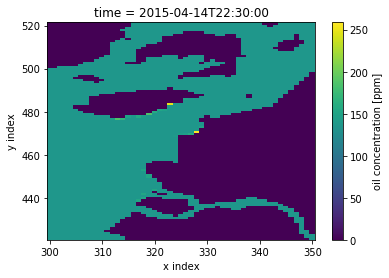

In [12]:
ds.oil_conc_2d.sel(
    time="2015-04-14 22:30:00", 
    grid_y=slice(421, 521), 
    grid_x=slice(300, 350),
).plot()